In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.tri as tri
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
%matplotlib inline

# 0. Functions

In [2]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [34]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'2.8% Median: {med1} \n Stats: {stat1} \n')
    print(f'5.6% Median: {med2} \n Stats: {stat2} \n')
    print(f'8.4% Median: {med3} \n Stats: {stat3} \n')
    print(f'11.2% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    return meds, maxs

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    print(f'AGR Median: {medagr} \n Stats: {statagr} \n')
    print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    means = [statpwr.mean, statagr.mean, statphwr.mean, statall.mean]
    return meds, maxs, means

In [29]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Log Likelihood', fontsize=14, labelpad=15)
        ax.set_xlim(0, 9000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [5]:
pklfile = '../../prep-pkls/nucmoles_mlecompare_sep2019/bigger-mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

In [39]:
XY.sample(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
62752,3946.57,2025.370584,3.770,agr,agr,0.003888,1.1900,1.1870,0.002132,0.5384,0.9666,0.03956,0.001414,5.640,0.6790,0.10170,0.005932,0.01168,0.1940,0.09316
70673,3619.13,1700.952536,0.711,candu37,phwr,0.001925,1.1060,1.0950,0.001264,0.3058,0.9100,0.03017,0.000896,3.481,0.2293,0.01216,0.000472,0.01095,0.1705,0.09104
123892,7788.96,3837.063114,0.711,candu37,phwr,0.006583,2.3620,2.3320,0.000862,0.6263,1.6970,0.07743,0.002595,6.481,0.9629,0.06794,0.008424,0.01061,0.3843,0.22180
103777,7383.80,3455.113414,2.990,ce14x14,pwr,0.009418,2.2020,2.1920,0.002386,0.5263,1.6590,0.09721,0.004279,11.920,1.7120,0.39830,0.044220,0.01824,0.3891,0.19580
37968,2342.03,1806.188181,4.020,agr,agr,0.001685,0.7068,0.7055,0.000952,0.3217,0.5818,0.02106,0.000541,3.890,0.2893,0.02841,0.000928,0.01152,0.1087,0.04841
39436,2648.32,1726.109085,4.020,agr,agr,0.002038,0.7983,0.7966,0.001303,0.3638,0.6606,0.02433,0.000699,4.284,0.3573,0.03986,0.001463,0.01159,0.1245,0.05645
39332,2648.32,1470.515087,4.020,agr,agr,0.002038,0.7983,0.7966,0.001647,0.3638,0.6714,0.02433,0.000740,4.284,0.3573,0.04123,0.001463,0.01159,0.1245,0.05645
90041,5963.75,3898.427007,4.360,agr,agr,0.008118,1.7900,1.7810,0.000884,0.8270,1.2940,0.06952,0.002214,7.763,1.3150,0.23420,0.027430,0.01236,0.3048,0.15190
77760,5061.69,2838.580240,3.200,ce14x14,pwr,0.005209,1.5130,1.5130,0.002030,0.3655,1.1810,0.05824,0.002308,9.513,1.0010,0.18960,0.012820,0.01788,0.2553,0.12740
84362,6739.31,3217.580365,3.200,ce14x14,pwr,0.008111,2.0030,1.9940,0.002484,0.4880,1.5310,0.08560,0.003761,11.450,1.5080,0.35390,0.034310,0.01822,0.3492,0.17570


## (a) Get test sample for LL calcs

In [40]:
# Choosing PHWR sample intentionally
sim_idx = 70673
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
70673,phwr,1700.952536,0.711,3619.13,candu37


## (b) LL calcs for uncertainty = 2.8%, 5.6%, 8.4%, 11.2%

In [41]:
fullXY = XY.loc[XY['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [42]:
uncs = [0.028, 0.056, 0.084, 0.112]
for unc in uncs:
    ll_name = 'LogLikelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
#    unc_name = 'LLUncertainty_' + str(unc)
#    trainXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

## (c) Half trainset + full trainset

In [43]:
trainXY = fullXY.sample(frac=0.5)

# 2. LogLikelihood for 3 reactors with Uncertainty = 11%

In [44]:
ll = 'LogLikelihood_0.112'
zname = [ll, ll, ll, ll]
rxtrs = ['PWR', 'AGR', 'PHWR', 'All']

## (a) Half trainset

In [52]:
trainXY_pwr = trainXY.loc[trainXY['ReactorType'] == 'pwr'].copy()
trainXY_agr = trainXY.loc[trainXY['ReactorType'] == 'agr'].copy()
trainXY_phwr = trainXY.loc[trainXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs, means = getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll)
plotXY1 = trainXY_pwr.loc[trainXY_pwr[ll] > meds[0]]
plotXY2 = trainXY_agr.loc[trainXY_agr[ll] > meds[1]]
plotXY3 = trainXY_phwr.loc[trainXY_phwr[ll] > meds[2]]
plotXY4 = trainXY.loc[trainXY[ll] > meds[3]]

PWR Median: -196.51674706935637 
 Stats: DescribeResult(nobs=21292, minmax=(-1.3841269894258917e+31, -21.447185594199926), mean=-1.6250020277033825e+29, variance=2.2226712208846498e+60, skewness=-9.065312178071782, kurtosis=80.1798862123061) 

AGR Median: -190.65221284505816 
 Stats: DescribeResult(nobs=21292, minmax=(-5.7049040925960074e+29, -18.20086981599673), mean=-6.805587167576577e+27, variance=3.836386318445325e+57, skewness=-8.991042489308466, kurtosis=78.83884504455013) 

PHWR Median: -247.93208692754223 
 Stats: DescribeResult(nobs=21294, minmax=(-2.172595291532498e+32, 64.62690609618124), mean=-2.6323357767076243e+30, variance=5.649973679284431e+62, skewness=-8.918920809718779, kurtosis=77.54714841003461) 

All Median: -200.86988288639458 
 Stats: DescribeResult(nobs=63878, minmax=(-2.172595291532498e+32, 64.62690609618124), mean=-9.339337003126309e+29, variance=1.9052695836242582e+62, skewness=-15.550646754490852, kurtosis=240.6722699781386) 



/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


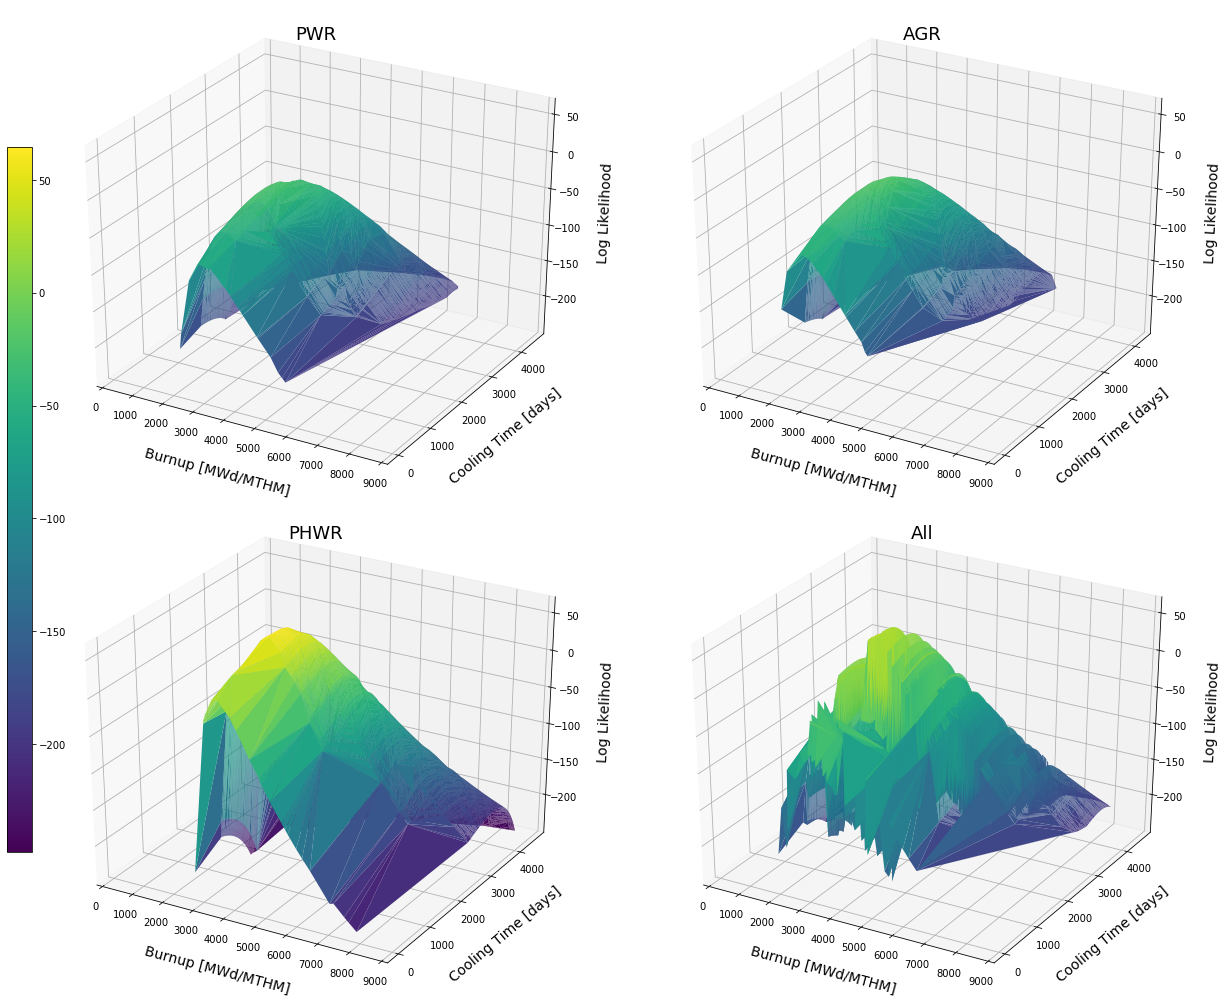

In [53]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=min(meds), vmax=max(maxs)) #vmin=meds[-1] vmin=min(meds)

## (b) Full trainset

In [16]:
fullXY_pwr = fullXY.loc[fullXY['ReactorType'] == 'pwr'].copy()
fullXY_agr = fullXY.loc[fullXY['ReactorType'] == 'agr'].copy()
fullXY_phwr = fullXY.loc[fullXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs = getstats_rxtr(fullXY_pwr, fullXY_agr, fullXY_phwr, fullXY, ll)
plotXY1 = fullXY_pwr.loc[fullXY_pwr[ll] > meds[0]]
plotXY2 = fullXY_agr.loc[fullXY_agr[ll] > meds[1]]
plotXY3 = fullXY_phwr.loc[fullXY_phwr[ll] > meds[2]]
plotXY4 = fullXY.loc[fullXY[ll] > meds[3]]

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


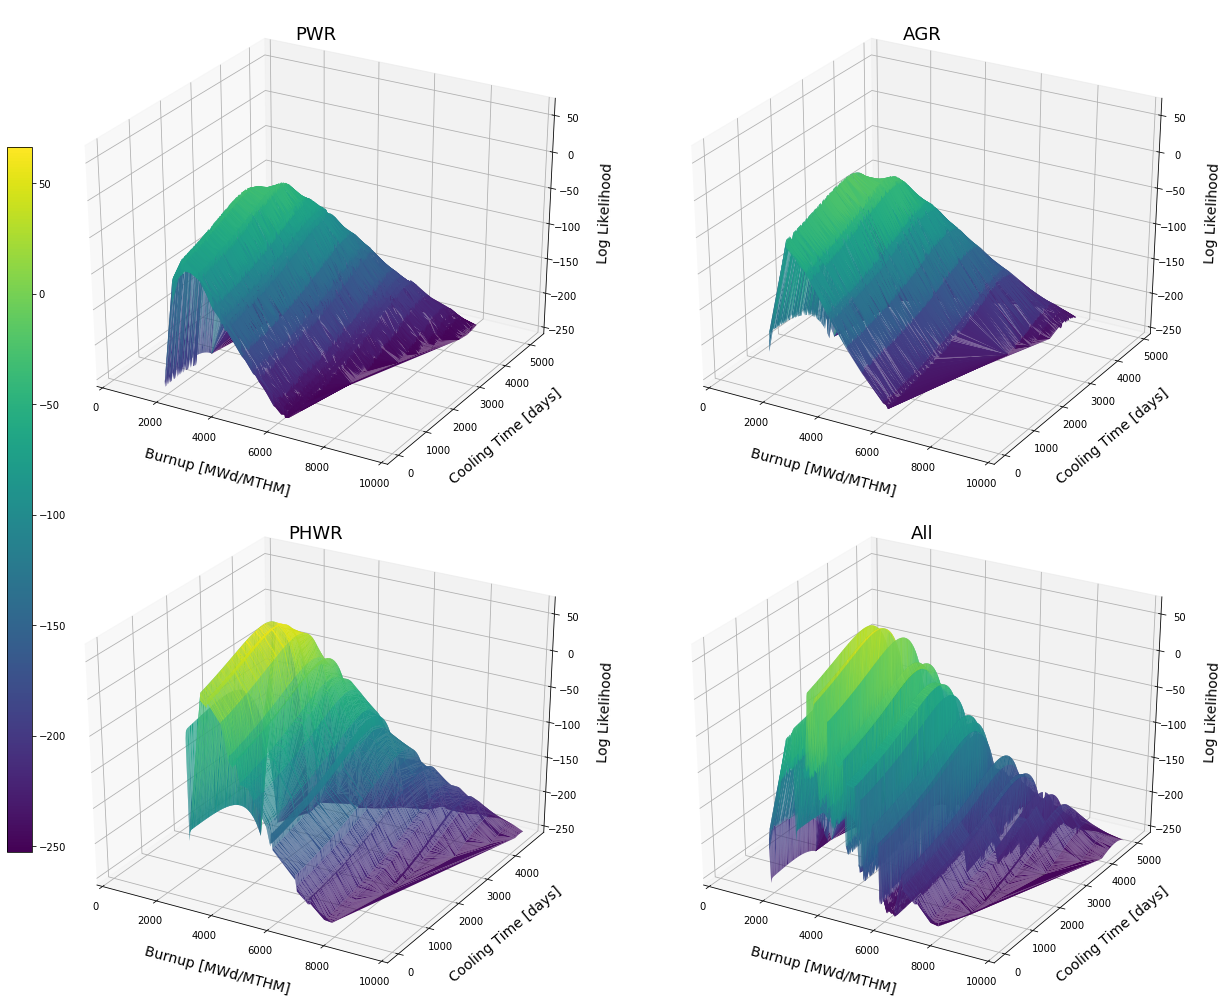

In [17]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=min(meds), vmax=max(maxs))

# 3. LogLikelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [54]:
ll1 = 'LogLikelihood_0.028'
ll2 = 'LogLikelihood_0.056'
ll3 = 'LogLikelihood_0.084'
ll4 = 'LogLikelihood_0.112'
zname = [ll1, ll2, ll3, ll4]
uncss = ['2.8% Unc', '5.6% Unc', '8.4% Unc', '11.2% Unc']

## (a) Half trainset

In [55]:
meds, maxs = getstats_unc(trainXY, ll1, ll2, ll3, ll4)

2.8% Median: -3950.2237913841764 
 Stats: DescribeResult(nobs=63878, minmax=(-3.4761524664519967e+33, 85.3544534863839), mean=-1.4942939205002095e+31, variance=4.877490134078101e+64, skewness=-15.550646754490852, kurtosis=240.6722699781386) 

5.6% Median: -943.8709135483521 
 Stats: DescribeResult(nobs=63878, minmax=(-8.690381166129992e+32, 74.96123088114139), mean=-3.7357348012505236e+30, variance=3.048431333798813e+63, skewness=-15.550646754490852, kurtosis=240.6722699781386) 

8.4% Median: -391.96323443551876 
 Stats: DescribeResult(nobs=63878, minmax=(-3.8623916293911064e+32, 68.90411041305997), mean=-1.6603265783335656e+30, variance=6.021592758121105e+62, skewness=-15.550646754490863, kurtosis=240.67226997813887) 

11.2% Median: -200.86988288639458 
 Stats: DescribeResult(nobs=63878, minmax=(-2.172595291532498e+32, 64.62690609618124), mean=-9.339337003126309e+29, variance=1.9052695836242582e+62, skewness=-15.550646754490852, kurtosis=240.6722699781386) 



In [56]:
cutoff = -4000

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


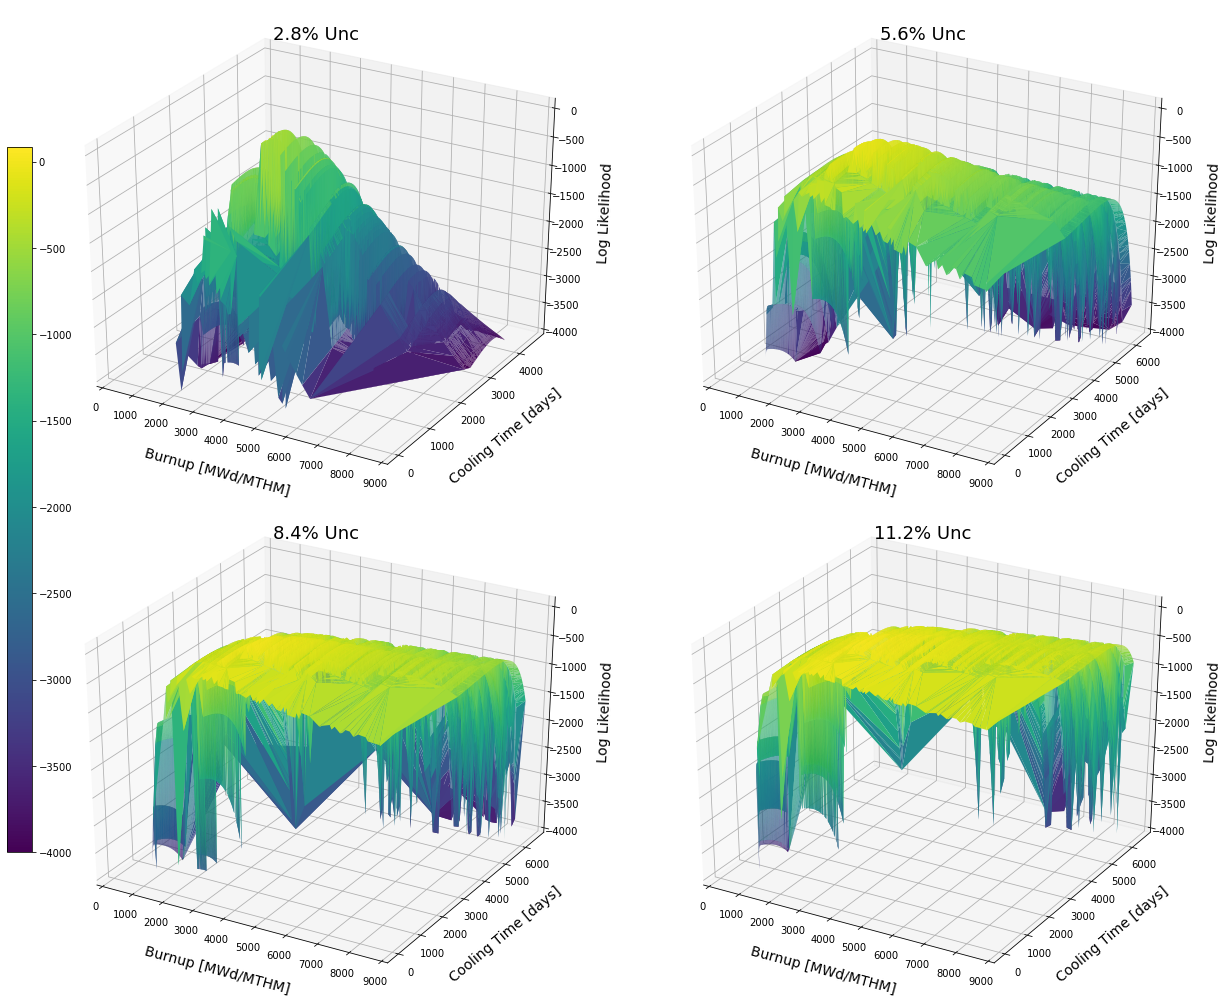

In [57]:
plotXY1 = trainXY.loc[trainXY[ll1] > cutoff]
plotXY2 = trainXY.loc[trainXY[ll2] > cutoff]
plotXY3 = trainXY.loc[trainXY[ll3] > cutoff]
plotXY4 = trainXY.loc[trainXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=max(maxs))

## (b) Full trainset

In [22]:
meds, maxs = getstats_unc(fullXY, ll1, ll2, ll3, ll4)

2.8% Median: -4654.185386669311 
 Stats: DescribeResult(nobs=73146, minmax=(-52306366591.27543, 87.24558183615221), mean=-248348075.00318956, variance=5.162133924256292e+18, skewness=-10.169449232832395, kurtosis=110.16796369125029) 

5.6% Median: -1124.0823739282782 
 Stats: DescribeResult(nobs=73146, minmax=(-13076591552.354626, 76.85047198887432), mean=-62086970.41849152, variance=3.226333649269764e+17, skewness=-10.169449259289005, kurtosis=110.16796431767646) 

8.4% Median: -474.304301367418 
 Stats: DescribeResult(nobs=73146, minmax=(-5811818401.155492, 70.76903867031615), mean=-27594177.42974485, variance=6.37300456352738e+16, skewness=-10.169449303383347, kurtosis=110.16796536171978) 

11.2% Median: -248.86582710883954 
 Stats: DescribeResult(nobs=73146, minmax=(-3269147800.4223323, 66.46270083428878), mean=-15521702.070222782, variance=2.016458397317569e+16, skewness=-10.169449365115364, kurtosis=110.16796682337954) 



/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


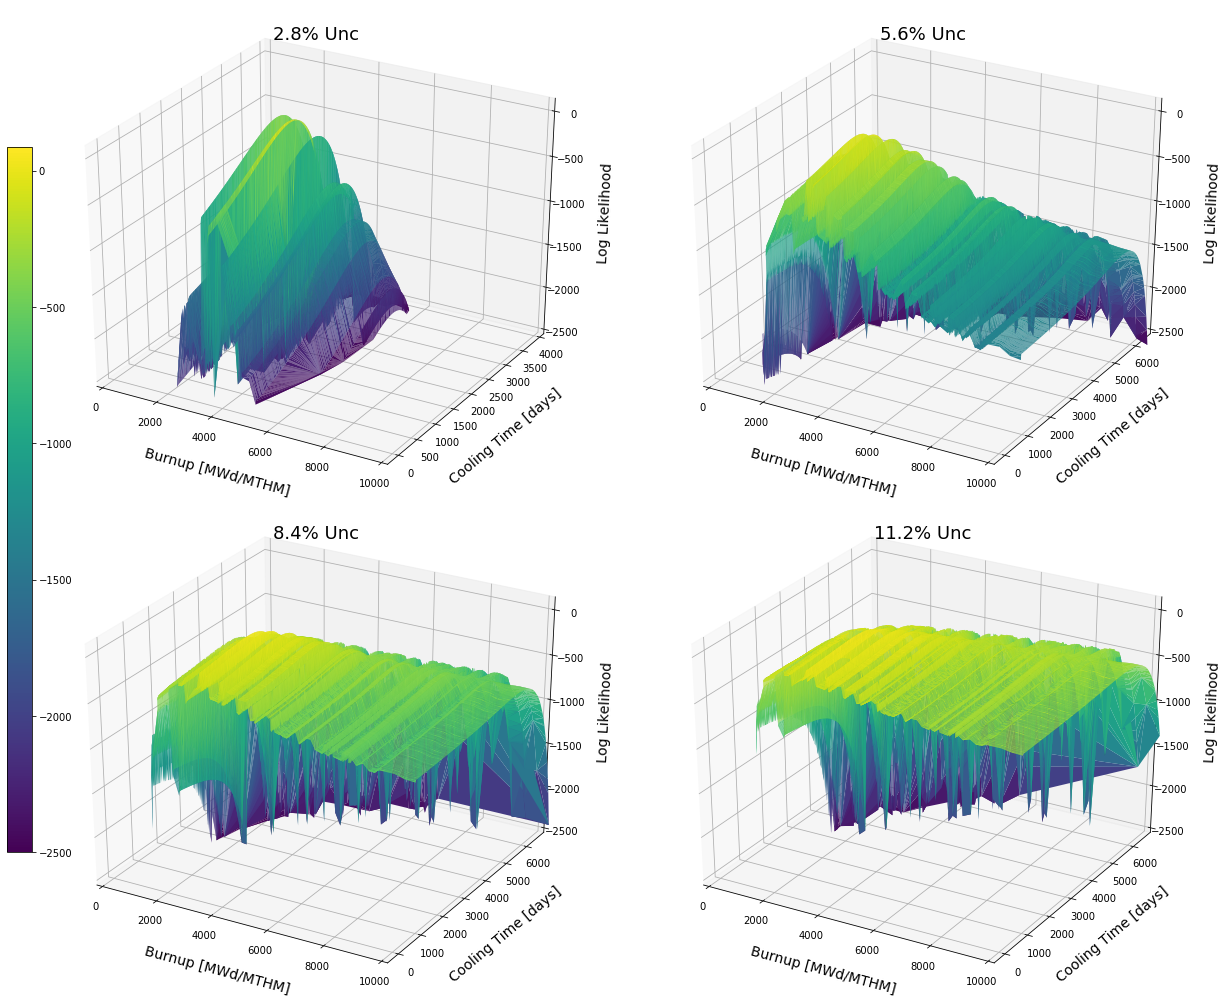

In [23]:
plotXY1 = fullXY.loc[fullXY[ll1] > cutoff]
plotXY2 = fullXY.loc[fullXY[ll2] > cutoff]
plotXY3 = fullXY.loc[fullXY[ll3] > cutoff]
plotXY4 = fullXY.loc[fullXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=max(maxs))